In [90]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn.functional import pad
from transformers import AutoTokenizer, BertForTokenClassification
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from torch.optim import AdamW 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split, Dataset

In [3]:
df = pd.read_csv('data/ner/NER dataset.csv', encoding='unicode_escape')
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [4]:
df.rename(columns={"Sentence #": "Sentence"}, inplace=True)
df["Tag"] = df["Tag"].apply(lambda x: x.upper())
df["TagGeneral"] = df["Tag"].apply(lambda x: x.split("-")[-1])
df["TagPos"] = df["Tag"].apply(lambda x: x.split("-")[0])
df["Word"] = df["Word"].fillna("None")

df.head(10)

,Sentence,Word,POS,Tag,TagGeneral,TagPos
0,Sentence: 1,Thousands,NNS,O,O,O
1,NaN,of,IN,O,O,O
2,NaN,demonstrators,NNS,O,O,O
3,NaN,have,VBP,O,O,O
4,NaN,marched,VBN,O,O,O
5,NaN,through,IN,O,O,O
6,NaN,London,NNP,B-GEO,GEO,B
7,NaN,to,TO,O,O,O
8,NaN,protest,VB,O,O,O
9,NaN,the,DT,O,O,O


In [5]:
tag_list = df["Tag"].unique()
df['Tag'].unique()

array(['O', 'B-GEO', 'B-GPE', 'B-PER', 'I-GEO', 'B-ORG', 'I-ORG', 'B-TIM',
       'B-ART', 'I-ART', 'I-PER', 'I-GPE', 'I-TIM', 'B-NAT', 'B-EVE',
       'I-EVE', 'I-NAT'], dtype=object)

In [6]:
tag_general = df['TagGeneral'].unique()
df['TagGeneral'].unique()

array(['O', 'GEO', 'GPE', 'PER', 'ORG', 'TIM', 'ART', 'NAT', 'EVE'],
      dtype=object)

In [7]:
tag2i = {tag : i for i, tag in enumerate(tag_list)}
i2tag = {i : tag for i, tag in enumerate(tag_list)}

In [8]:
tagGeneral2i = {tag : i for i, tag in enumerate(tag_general)}
i2tagGeneral = {i : tag for i, tag in enumerate(tag_general)}

In [9]:
df.head(10)

,Sentence,Word,POS,Tag,TagGeneral,TagPos
0,Sentence: 1,Thousands,NNS,O,O,O
1,NaN,of,IN,O,O,O
2,NaN,demonstrators,NNS,O,O,O
3,NaN,have,VBP,O,O,O
4,NaN,marched,VBN,O,O,O
5,NaN,through,IN,O,O,O
6,NaN,London,NNP,B-GEO,GEO,B
7,NaN,to,TO,O,O,O
8,NaN,protest,VB,O,O,O
9,NaN,the,DT,O,O,O


<Axes: >

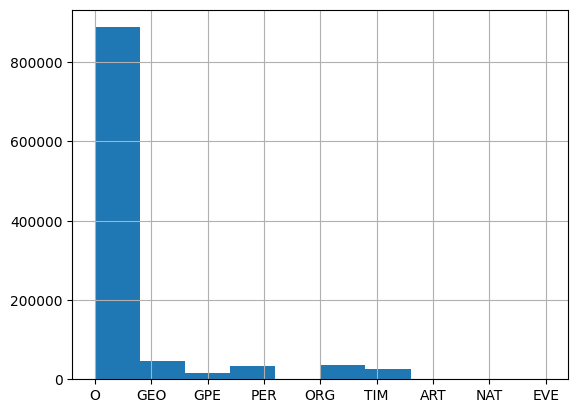

In [10]:
df['TagGeneral'].hist()

<Axes: >

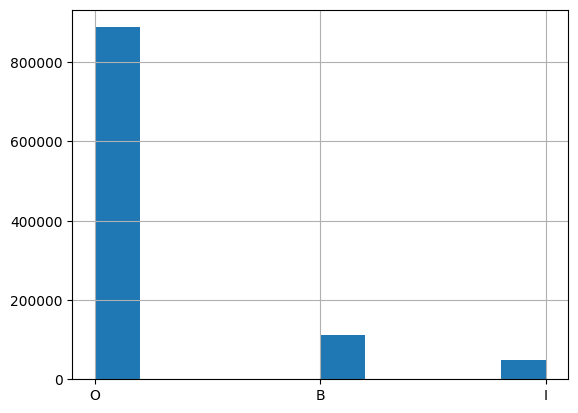

In [11]:
df['TagPos'].hist()

In [12]:
df["Sentence"] = df["Sentence"].ffill()
df = df.groupby(by="Sentence").agg(list).reset_index().drop("Sentence", axis=1)
df.head(20)

,Word,POS,Tag,TagGeneral,TagPos
0,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO...","[O, O, O, O, O, O, GEO, O, O, O, O, O, GEO, O,...","[O, O, O, O, O, O, B, O, O, O, O, O, B, O, O, ..."
1,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, O...","[B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-TIM, O, O, O, O, O, B-GEO, O, O, O, O...","[O, O, TIM, O, O, O, O, O, GEO, O, O, O, O, O,...","[O, O, B, O, O, O, O, O, B, O, O, O, O, O, B, ..."
3,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]"
4,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-GEO, O, O, B-PER, I-PER, O, B-TIM, O, B-GEO...","[GEO, O, O, PER, PER, O, TIM, O, GEO, O, GPE, ...","[B, O, O, B, I, O, B, O, B, O, B, O, B, O, O, ..."
5,"[Mr., Egeland, said, the, latest, figures, sho...","[NNP, NNP, VBD, DT, JJS, NNS, VBP, CD, CD, NNS...","[B-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O...","[PER, PER, O, O, O, O, O, O, O, O, O, O, O, O,...","[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6,"[He, said, last, week, 's, tsunami, and, the, ...","[PRP, VBD, JJ, NN, POS, NN, CC, DT, JJ, NN, NN...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7,"[Some, 1,27,000, people, are, known, dead, .]","[DT, CD, NNS, VBP, VBN, JJ, .]","[O, O, O, O, O, O, O]","[O, O, O, O, O, O, O]","[O, O, O, O, O, O, O]"
8,"[Aid, is, being, rushed, to, the, region, ,, b...","[NNP, VBZ, VBG, VBN, TO, DT, NN, ,, CC, DT, NN...","[O, O, O, O, O, O, O, O, O, O, B-GEO, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, GEO, O, O, O, O...","[O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, ..."
9,"[Lebanese, politicians, are, condemning, Frida...","[JJ, NNS, VBP, VBG, NNP, POS, NN, NN, IN, DT, ...","[B-GPE, O, O, O, B-TIM, O, O, O, O, O, O, O, O...","[GPE, O, O, O, TIM, O, O, O, O, O, O, O, O, GE...","[B, O, O, O, B, O, O, O, O, O, O, O, O, B, O, ..."


In [13]:
df["TagId"] = df.apply(lambda x : [tag2i[tag] for tag in x['Tag']], axis=1)
df.head(20)

,Word,POS,Tag,TagGeneral,TagPos,TagId
0,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO...","[O, O, O, O, O, O, GEO, O, O, O, O, O, GEO, O,...","[O, O, O, O, O, O, B, O, O, O, O, O, B, O, O, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[GPE, O, O, O, O, O, O, O, O, O, O, O, O, O, O...","[B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-TIM, O, O, O, O, O, B-GEO, O, O, O, O...","[O, O, TIM, O, O, O, O, O, GEO, O, O, O, O, O,...","[O, O, B, O, O, O, O, O, B, O, O, O, O, O, B, ...","[0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, ..."
3,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-GEO, O, O, B-PER, I-PER, O, B-TIM, O, B-GEO...","[GEO, O, O, PER, PER, O, TIM, O, GEO, O, GPE, ...","[B, O, O, B, I, O, B, O, B, O, B, O, B, O, O, ...","[1, 0, 0, 3, 10, 0, 7, 0, 1, 0, 2, 0, 2, 0, 0,..."
5,"[Mr., Egeland, said, the, latest, figures, sho...","[NNP, NNP, VBD, DT, JJS, NNS, VBP, CD, CD, NNS...","[B-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O...","[PER, PER, O, O, O, O, O, O, O, O, O, O, O, O,...","[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[3, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,"[He, said, last, week, 's, tsunami, and, the, ...","[PRP, VBD, JJ, NN, POS, NN, CC, DT, JJ, NN, NN...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,"[Some, 1,27,000, people, are, known, dead, .]","[DT, CD, NNS, VBP, VBN, JJ, .]","[O, O, O, O, O, O, O]","[O, O, O, O, O, O, O]","[O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0]"
8,"[Aid, is, being, rushed, to, the, region, ,, b...","[NNP, VBZ, VBG, VBN, TO, DT, NN, ,, CC, DT, NN...","[O, O, O, O, O, O, O, O, O, O, B-GEO, O, O, O,...","[O, O, O, O, O, O, O, O, O, O, GEO, O, O, O, O...","[O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
9,"[Lebanese, politicians, are, condemning, Frida...","[JJ, NNS, VBP, VBG, NNP, POS, NN, NN, IN, DT, ...","[B-GPE, O, O, O, B-TIM, O, O, O, O, O, O, O, O...","[GPE, O, O, O, TIM, O, O, O, O, O, O, O, O, GE...","[B, O, O, O, B, O, O, O, O, O, O, O, O, B, O, ...","[2, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


In [14]:
df.shape

(47959, 6)

In [15]:
n_tags = len(tag_list)

In [16]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", do_lower_case=True)
tokenizer.decode(tokenizer.encode("Hey you"))

'[CLS] hey you [SEP]'

In [17]:
tokenizer(["Hey", "you", ",", "there", "!"], is_split_into_words=True)

{'input_ids': [101, 23998, 1128, 117, 1175, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [18]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels = n_tags,
    output_attentions = False,
    output_hidden_states = False,
)
model

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [20]:
test = "Nobody working at Apple is allowed to eat an apple"
encoded_dict = tokenizer(test, return_tensors = 'pt')
output = model(**encoded_dict)
output.logits.shape

torch.Size([1, 12, 17])

In [21]:
n_tags

17

In [22]:
encoded_dict = tokenizer("Hey you")
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [23]:
encoded_dict['input_ids']

[101, 23998, 1128, 102]

In [24]:
encoded_dict['token_type_ids']

[0, 0, 0, 0]

In [25]:
encoded_dict['attention_mask']

[1, 1, 1, 1]

In [102]:
class CustomDataloader(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.data = df['Word'].values
        self.label = df['TagId'].values
        self.tokenizer = tokenizer

    def __len__(self, ):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        words = self.data[idx]
        labels = self.label[idx]
        encoded_dict = self.tokenizer(words, 
                         is_split_into_words=True,
                         add_special_tokens = True,
                         return_attention_mask = True,
                         return_tensors = 'pt',
        )

        labels = [-100 if word_id is None else labels[word_id] for word_id in encoded_dict.word_ids()]
        
        return encoded_dict['input_ids'][0], \
               encoded_dict['token_type_ids'][0], \
               encoded_dict['attention_mask'][0], \
               torch.tensor(labels).to(torch.int64)

    def __create_token_labels(self, labels, word_ids ):
        extended_labels = [-100 if word_id is None else labels[word_id] for word_id in word_ids]
        return torch.tensor(extended_labels).to(torch.int64)

cd = CustomDataloader(df, tokenizer)
x = cd[10]
tokenizer.decode(x[0])
len(cd)

47959

In [103]:
output = model(input_ids=x[0].unsqueeze(dim=0), token_type_ids=x[1].unsqueeze(dim=0), attention_mask=x[2].unsqueeze(dim=0))

In [104]:
def collate_fn(batch):
    max_len = max([len(b[0]) for b in batch])
    ids = []
    token_types = []
    attn_masks = []
    labels = []

    for b in batch:
        pad_length = max_len - len(b[0])
        ids.append(pad(b[0], (0, pad_length), value=0))
        token_types.append(pad(b[1], (0, pad_length), value=0))
        attn_masks.append(pad(b[2], (0, pad_length), value=0))
        labels.append(pad(b[3], (0, pad_length), value=-100))

    return torch.stack(ids), torch.stack(token_types), torch.stack(attn_masks), torch.stack(labels)

In [105]:
dataset = CustomDataloader(df, tokenizer)
train_size = int (0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

In [106]:
batch_size = 8

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

In [107]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )

In [108]:
batch = next(iter(train_dataloader))

In [110]:
NUM_EPOCH = 4
training_loss = []
validation_loss = []

for epoch in range(NUM_EPOCH):
    running_training_loss = 0
    running_validation_loss = 0

    model.train()
    loop = tqdm(train_dataloader)
    for batch in loop:
        optimizer.zero_grad()
        output = model(input_ids=batch[0],
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])
        loss = output.loss
        running_training_loss += loss.item()
        loss.backward()
        optimizer.step()
        loop.set_description(f"Training. Epoch [{epoch}/{NUM_EPOCH}]. Loss {loss.item()}")

    training_loss.append(running_training_loss / train_size)

    model.eval()
    loop = tqdm(validation_dataloader)
    for batch in loop:
        output = model(input_ids=batch[0],
                       token_type_ids=batch[1],
                       attention_mask=batch[2],
                       labels=batch[3])
        loss = output.loss
        running_validation_loss += loss.item()
    validation_loss.append(running_validation_loss / validation_size)

Training. Epoch [0/4]. Loss 0.17375658452510834:   8%|█████████▏                                                                                                             | 371/4796 [03:33<42:22,  1.74it/s]


KeyboardInterrupt: 

tensor(2.7227, grad_fn=<NllLossBackward0>)